In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import sklearn

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')

# Import useful functions for this script  
from tracking import track

track("-"*25 + "CLUSTERING" + "-"*25)

# Reading data

#### Define path to data files

In [2]:
track("Defining path to data files")

# Define base path to data files
path = '../../temp_data/'

# Define path to the preprocesseded dataset that will be used in this script
path_preprocessed_data = path + 'model_data.csv'

# Ensure the input file exists
assert os.path.isfile(path_preprocessed_data), f'{path_preprocessed_data} not found. Is it a file?'

#### Read the files

In [3]:
# Read table with preprocesseded data that will be used in this script
track("Reading preprocessed data")
preprocessed_data = pd.read_csv(path_preprocessed_data)
track("Finished reading preprocessed data")

In [4]:
# Drop the column containing the name of the author
data = preprocessed_data.loc[:, preprocessed_data.columns != 'author']
track("Author column was dropped")

# Model

In [5]:
def optimization_parameters_UMAP(data, c):
    """
    Objective:
        - Find the optimal values (n_neighbors, min_dist) for the UMAP parameters given the number of components (c)
    Input:
        - dataset: standardized dataframe 
        - c: number of components (10)
    Output:
        - n_optim: value for the optimum number of neighbors 
        - d_optim: value for the optimum number for the min_dist parameter
    """
    track('Performing hyperparameter optimization UMAP ...')
    trustworthiness = 0
    n_neighbors = [5, 10, 30, 40]
    min_dist = [0.01, 0.05, 0.1]
    n_optim = 2
    d_optim = 0
    for n in n_neighbors:
        for d in min_dist:
            UMAP_data = compute_UMAP(data,n_neighbors=n,min_dist=d,n_components=c)
            t = sklearn.manifold.trustworthiness(data, UMAP_data, n_neighbors=n, metric='euclidean')
            if t > trustworthiness:
                n_optim = n
                d_optim = d

    # t value will be between [0, 1].
    return (n_optim, d_optim)


def save_plot(fig,type_model,filename):
    '''
    Objective:
        - Save plots
    Input:
        - fig: figure we want to save
        - type_model: K-means
        - filename: Name of the file 
    Output:
        - None
    '''

    # Path and name of the file/figure we want to save
    path = '../../reports/figures/models'+"/"+type_model
    file_name = path+"/"+filename+".png"
    # Directory creation if doesn't exists
    try:
        os.makedirs(path)
    except OSError:
        pass
    else:
        track("Successfully created the directory %s" % path)

    # Save the figure/file
    if (os.path.exists(file_name)== True):
        track ("Warning: Figure %s already created" % path)
        track('Figure will be overwritten')
        plt.savefig(file_name, transparent=True)
    else:
        plt.savefig(file_name, transparent=True)
    track("Successfully saved %s" % path)

def transform_dataset(dataset, type):
    '''
    Objective:
        - Scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
    Input:
        - dataset: Pandas dataframe 
        - type: "min_max" or "standard"
    Output:
        - Transformed data
    '''
    if type == "min_max":
        transformer = MinMaxScaler()
    elif type == "standard":
        transformer = StandardScaler()
    else:
        print("The type of transformation {} is not supported. The supported transformations are: min_max and standard".format(type))
    col = dataset.columns
    result = transformer.fit_transform(dataset)
    transformed_data = pd.DataFrame(result, columns=col)

    return transformed_data

def f_silhouette_score(dataset,total_clusters):
    '''
    Objective:
        - Compute the silhouette_score
    Input:
        - dataset: Normalized dataframe 
        - total_clusters: Maximum number of clusters
    Output:
        - Number of clusters that has the biggest value of silhouette_score
    '''      

    max_value = 0
    k = 0
    for n_cluster in range(2, total_clusters):
        kmeans = KMeans(n_clusters=n_cluster).fit(dataset)
        label = kmeans.labels_
        sil_coeff = silhouette_score(dataset, label, metric='euclidean')
        sil_coeff = silhouette_score(dataset, label, metric='euclidean')
        sil_coeff = silhouette_score(dataset, label, metric='euclidean')
        if sil_coeff > max_value:
            max_value = sil_coeff
            k = n_cluster
        track("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    print("silhouette_score", max_value)
    
    return k, max_value

def WCSS_and_Elbow_Method(dataset,max_k):
    '''
    Objective:
        - Compute the WCSS_and_Elbow_Method
    Input:
        - dataset: Normalized dataframe 
        - total_clusters: Maximum number of clusters
    Output:
        - Save the plot of number of clusters vs inertia
    '''

    wcss=[]
    for i in range(1,max_k):
        # Kmeans with i clusters
        kmeans = KMeans(i)
        kmeans.fit(dataset)
        # Compute the inertia
        inertia = kmeans.inertia_        

        # Save the inertia of each iteration
        wcss.append(inertia)  

    # Plot the number of clusters vs inertia 
    number_clusters = range(1,max_k)
    fig = plt.plot(number_clusters,wcss, 'bx-')
    plt.title('WCSS and Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS (Elbow Method For Optimal k)')
    save_plot(fig,"K-means",'WCSS_and_Elbow_Method')


def define_num_clusters(dataset, min_k, max_k): 
    '''
    Objective:
        - Compute the optimal number of clusters with WCSS and Elbow Method and silhouette_score
    Input:
        - dataset: scaled dataframe 
        - min_k: minimum number of clusters to be used
        - max_k : maximum number of clusters to be used 
    Output:
        - List containing the cluster assigned to each row
    '''

    # To ensure reproducibility
    np.random.seed(0)

    # Compute the inertia and plot the graphic between insertia ans number of clusters
    WCSS_and_Elbow_Method(dataset,max_k)

    # Choosing the number of clusters with the silhouette_score
    number_of_clusters, silhouette = f_silhouette_score(dataset,max_k)
    
    # Change the number of clusters to min_k if the number selected was smaller than this number
    if number_of_clusters < min_k:
        print('Number of clusters changed to', min_k)
        number_of_clusters = min_k

    # Once selected the number of clusters, compute the cluster of each row and added to the dataframe
    kmeans = KMeans(number_of_clusters)
    kmeans.fit(dataset)
    identified_clusters = kmeans.fit_predict(dataset)
    iner = kmeans.inertia_
    print("total inertia", iner)
    print("Number of clusters", number_of_clusters)
    
    return (identified_clusters,number_of_clusters,silhouette)

def compute_PCA(dataset, min_var):
    '''
    Objective:
        - Compute PCA 
    Input:
        - dataset: min max scaled dataframe 
        - min_var: minimum explained variance
    Output:
        - PCA data
    '''
    track('Performing PCA on dataset ...')
    # Take the number of components that explain more than a 0.955% of the variance
    pca = PCA(n_components = min_var)
    principal_components = pca.fit_transform(dataset)
    pca_df = pd.DataFrame(data = principal_components)
    track("explained variance in PCA:{}".format(sum(pca.explained_variance_ratio_)))
    print("explained variance in PCA:{}".format(sum(pca.explained_variance_ratio_)))
    print("PCA components:{}".format(pca_df.shape[1]))
    
    return pca_df

def compute_UMAP(dataset,n_neighbors,min_dist,n_components):
    '''
    Objective:
        - Compute UMAP 
    Input:
        - dataset: standardized dataframe 
        - n_neighbors: controls how UMAP balances local versus global structure in the data
        - min_dist: minimum distance apart that points are allowed to be in the low dimensional representation
        - n_components: dimensionality of the reduced dimension space
    Output:
        - UMAP data
    '''
    track('Performing UMAP on dataset ...')
    n_optim, d_optim = optimization_parameters_UMAP(dataset, n_components)
    reducer = UMAP(n_neighbors=n_optim,min_dist=d_optim,n_components=n_components,random_state=0)
    #reducer = UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,random_state=0)
    reduced_data = reducer.fit_transform(dataset)
    UMAP_df = pd.DataFrame(data = reduced_data)

    return UMAP_df


def plot_clusters(clusters, min_max_data, standardized_data,type):
    '''
    Objective:
        - Compute the PCA or UMAP plot
    Input:
        - clusters: Vector that contains the number of cluster each author belongs
        - min_max_data: Standardized data with MinMaxScaler
        - standardized_data: Standardized data with StandardScaler
    Output:
        - Save the PCA or UMAP plot
    '''
    clusters = pd.Series(clusters)
    
    if type == "PCA":
        pca = PCA(n_components=2)
        ## Perform PCA 
        # Fit the PCA to the data, and then transform the data into its principal components
        principal_components = pca.fit_transform(min_max_data)
        plots = 1
    
    elif type == "UMAP":
        ## Perform UMAP
        # Fit the UMAP to the data, and then transform the data into its principal components
        n_optim, d_optim = optimization_parameters_UMAP(standardized_data, 2)        
        reducer = UMAP(n_neighbors=n_optim,min_dist=d_optim,n_components=2,random_state=0)
        #reducer = UMAP(n_neighbors=40,min_dist=0.01,n_components=2,random_state=0)
        principal_components = reducer.fit_transform(standardized_data)
        plots = 1
    else:
        plots = 2
    
    for i in range(plots):
        if type == "None":
            if i == 0:
                ## Perform PCA
                pca = PCA(n_components=2)
                principal_components = pca.fit_transform(min_max_data)
            else:
                ## Perform UMAP
                reducer = UMAP(n_neighbors=40,min_dist=0.01,n_components=2,random_state=0)
                principal_components = reducer.fit_transform(standardized_data)

        # Dataframe of the two principal_components
        pcs_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
        ## Concatenate the labels as the last dimension of the principal components to create the results dataframe
        results_df = pd.concat([pcs_df, clusters], axis=1)
        results_df.columns = ['principal component 1', 'principal component 2', 'labels']
        plt.figure()
        f = sns.scatterplot(x='principal component 1', y='principal component 2', hue=clusters, data=results_df, linewidth=0, palette='Set2')
        plt.xlabel('Principal Component 1', fontsize = 12)
        plt.ylabel('Principal Component 2', fontsize = 12)
        if type == "UMAP" or type == "PCA":
            plt.title('{} Results'.format(type), fontsize = 12)
            plt.grid()
            plt.show()
            save_plot(f,type,"plot_"+type)
            plt.close()
        else:
            if i == 0:
                plt.title('PCA Results', fontsize = 12)  
                plt.grid()
                plt.show()
                save_plot(f,"PCA","plot_PCA")
                plt.close()
            else:
                plt.title('UMAP Results', fontsize = 12) 
                plt.grid()
                plt.show()
                save_plot(f,"UMAP","plot_UMAP")
                plt.close()
    

#### K-means with normalized data

In [6]:
track("Starting mix max scaling of data")
# Min max scaling of data
track("Finished mix max scaling of data")
min_max_data = transform_dataset(data,type="min_max")

silhouette_score 0.6778298218106921
Number of clusters changed to 5
total inertia 85.85310799642518
Number of clusters 5


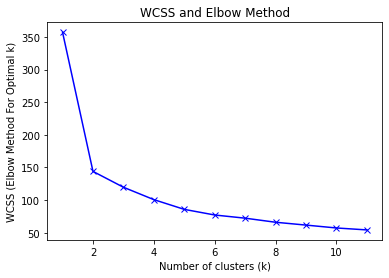

In [7]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_none , number_of_clusters_none , silhouette_none = define_num_clusters(min_max_data,min_k=5, max_k=12)
track("Finished WCSS and Elbow method for choosing the number of clusters")

#### K-means with PCA data

In [8]:
# Compute PCA
track("Starting to compute PCA")
PCA_data = compute_PCA(min_max_data, min_var=0.95)
track("Finished computing PCA")

explained variance in PCA:0.9538823881605283
PCA components:10


silhouette_score 0.6979909292706111
Number of clusters changed to 5
total inertia 70.02559414226049
Number of clusters 5


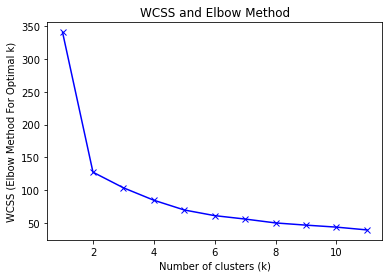

In [9]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_PCA, number_of_clusters_PCA, silhouette_PCA = define_num_clusters(PCA_data,min_k=5,max_k=12)
track("Finished WCSS and Elbow method for choosing the number of clusters")

#### K-means with UMAP data

In [14]:
track("Starting standardization of data")
# Standardization of data
track("Finished standardization of data")
standardized_data = transform_dataset(data,type="standard")

In [11]:
# Compute UMAP
track("Starting to compute UMAP")
UMAP_data = compute_UMAP(standardized_data,n_neighbors=40,min_dist=0.01,n_components=10)
track("Finished computing UMAP")

RecursionError: maximum recursion depth exceeded while calling a Python object

silhouette_score 0.7420633
Number of clusters changed to 5
total inertia 153.30311584472656
Number of clusters 5


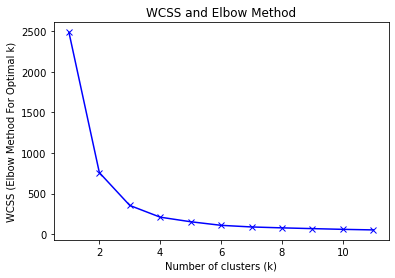

In [41]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_UMAP, number_of_clusters_UMAP, silhouette_UMAP = define_num_clusters(UMAP_data,min_k=5,max_k=12)
track("Finished WCSS and Elbow method for choosing the number of clusters")

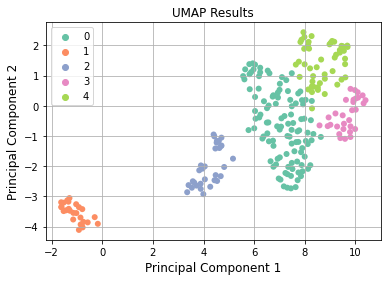

In [48]:
if silhouette_PCA > silhouette_UMAP and silhouette_PCA > silhouette_none:
    plot_clusters(clusters_PCA, min_max_data,standardized_data,"PCA")
elif silhouette_PCA < silhouette_UMAP and silhouette_UMAP > silhouette_none:
    plot_clusters(clusters_UMAP, min_max_data, standardized_data,"UMAP")
else: 
    plot_clusters(clusters_none, min_max_data, standardized_data,"None")

In [12]:
def optimization_parameters_UMAP_1 (data, c):
    '''
    Objective:
- Find the optimal values (n_neighbors, min_dist) for the UMAP parameters given the number of components (c)
Input:
- dataset: standardized dataframe 
- c: number of components (10)
Output:
- n_optim: value for the optimum number of neighbors 
- d_optim: value for the optimum number for the min_dist parameter
'''
    track('Performing hyperparameter optimization UMAP ...')
    trustworthiness = 0
    n_neighbors = [ 10, 20, 30, 40]
    min_dist = [ 0.01, 0.05, 0.1]
    n_optim = 2
    d_optim = 0
    for n in n_neighbors:
        for d in min_dist:
            UMAP_data = compute_UMAP(data,n_neighbors=n,min_dist=d,n_components=c)
            t = sklearn.manifold.trustworthiness(data, UMAP_data, n_neighbors=n, metric='euclidean')
            if t > trustworthiness:
                n_optim = n
                d_optim = d


    # t value will be between [0, 1].
    return n_optim, d_optim

In [15]:
optimization_parameters_UMAP_1(standardized_data,2)

RecursionError: maximum recursion depth exceeded while calling a Python object